In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors


from pandas import read_csv
from physics import JT_GMS, SMT
from constants import *

from scipy.optimize import root, curve_fit, least_squares
from scipy.interpolate import interp1d
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
""
from exp_setup import Cylindrical_Grid, Experiment, Measurements
# from TTM_solver import TwoTemperatureModel
from Hydro_solver import HydroModel

import cProfile

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
grid  = Cylindrical_Grid(200e-6, N=200) 
Z, A = 54, 131
n0 = 1.25e20 *1e6

dih_file = "/home/zach/plasma/TTM/data/Xe5bar_DIH_profile_data.txt"

model_kwargs = {'gas_name':'Xenon', 'model':"SMT", 'ion_temperature_model':'MD','ion_temperature_file':dih_file,
                'electron_temperature_model':'gaussian','Te_experiment_is_peak':True, 'super_gaussian_power':1}

Xe_data = read_csv("./data/experimental_data/Xe_5bar_Te.txt", delim_whitespace=True, header=1)
Xe_FWHM_data = read_csv("./data/experimental_data/Xe_5bar_FWHM.txt", delim_whitespace=True, header=1)

import warnings
# Suppress warnings from fitting initial conditions
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    def fit_initial_condition(Te_exp, FWHM_exp , **kwargs ):
        def find_exp_params(inputs):
            Te_peak, Te_FWHM = inputs
            Xenon_jt = Experiment(grid, n0, Z, A, Te_peak, Te_FWHM, **kwargs)

            ttm = HydroModel(Xenon_jt, model=kwargs['model'])
            exp = Measurements(Z, A, ttm.grid.r, ttm.n_e, ttm.n_i, ttm.Te, ttm.Ti, R_max = 100e-6, Nx =100, Nz=100)
            return Te_exp - exp.Te_fit, FWHM_exp - exp.FWHM 
#         sol = root(find_exp_params, (Te_exp, 2*FWHM_exp))
        sol = root(find_exp_params, (1.15*Te_exp, 102.4e-6))
        return sol

    initial_conditions = fit_initial_condition(Xe_data['T[kK]'][0]*1e3, Xe_FWHM_data['FWHM[μm]'][0]/1e6,**model_kwargs)
# Show success of initial condition fit     
print(initial_conditions)
Te_initial, gaussian_FWHM = initial_conditions.x
Xenon = Experiment(grid, n0, Z, A, Te_initial, gaussian_FWHM, **model_kwargs)

ttm = HydroModel(Xenon, model = model_kwargs["model"], electron_model='equilibrium')

# Print Setup
initial_setup = Measurements(Z, A, ttm.grid.r, ttm.n_e, ttm.n_i, ttm.Te, ttm.Ti, R_max = 200e-6, Nx =200, Nz=100)
print("\nExp: FWHM = {0:.2f} [μm], Te = {1:.2f} [kK]".format(Xe_FWHM_data['FWHM[μm]'][0], Xe_data['T[kK]'][0]))
print("Sim: FWHM = {0:.2f} [μm], Te = {1:.2f} [kK]".format(initial_setup.FWHM*1e6,initial_setup.Te_fit/1e3))

 message: The solution converged.
 success: True
  status: 1
     fun: [ 2.009e-03  8.598e-16]
       x: [ 1.851e+04  1.035e-04]
    nfev: 17
    fjac: [[-1.000e+00 -2.213e-13]
           [ 2.213e-13 -1.000e+00]]
       r: [-2.847e+02 -1.481e+10  4.896e-01]
     qtf: [-2.009e-03 -4.152e-16]


/home/zach/plasma/TTM/physics.py:305: RuntimeWarning: invalid value encountered in sqrt
  l_mfp = c/ν_ω * np.sqrt(1-γ)/γ
/home/zach/plasma/TTM/physics.py:355: RuntimeWarning: overflow encountered in exp
  B_λ = 4*π*hbar * c**2/λ**5 * 1/(np.exp(2*π*hbar*c/(λ*k_B*Te))-1)



Exp: FWHM = 51.18 [μm], Te = 16.61 [kK]
Sim: FWHM = 51.21 [μm], Te = 16.60 [kK]


# Contour Plot Mean Free Path

/tmp/ipykernel_4992/2981753146.py:8: RuntimeWarning: invalid value encountered in sqrt
  correction = crit_ratio_grid/np.sqrt(1-crit_ratio_grid)


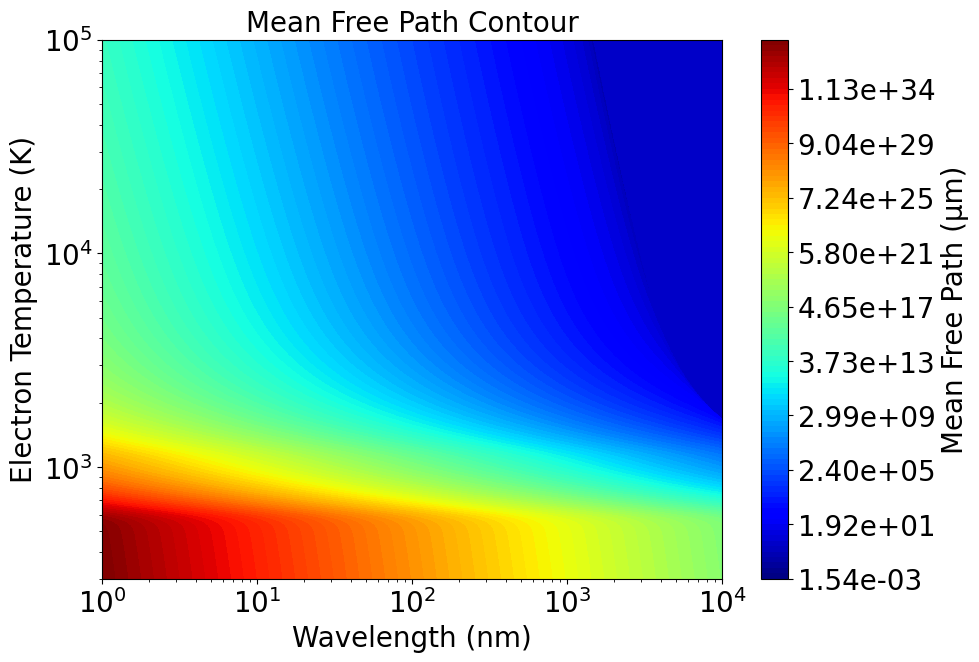

In [5]:
from matplotlib.colors import LogNorm
from matplotlib.ticker import FuncFormatter


def get_lγ_from_Te_Seth(ω, Te):
    Zbar = JT_GMS.Thomas_Fermi_Zbar(Z, n0, Te)*(np.exp(-2000**2/Te**2)+1e-5)
    Ti   = 1e3 # really irrelevant
    correction = crit_ratio_grid/np.sqrt(1-crit_ratio_grid)
    l = 1/correction*JT_GMS.photon_mean_free_path(ω, A*m_p, n0, Zbar*n0, Ti, Te, Zbar)
    return l

def get_lγ_from_Te_standard(ω, Te):
    Zbar = JT_GMS.Thomas_Fermi_Zbar(Z, n0, Te)*(np.exp(-2000**2/Te**2)+1e-5)
    Ti   = 1e3 # really irrelevant
    l = 1/JT_GMS.photon_absorption_coefficient(ω, A*m_p, n0, Zbar*n0, Ti, Te, Zbar)
    return l

# Create a grid of angular frequencies (ω) and electron temperatures (Te)
# λ_values = 1e-9*np.geomspace(400,700, 1000)  # m 
λ_values = 1e-9*np.geomspace(1, 1e4, 1000)
ω_values = 2*π*c/λ_values # Corresponds to 1 nm to 1000 nm
Te_values = np.geomspace(3e2, 1e5, 1000)  # K

# Create a 2D grid
ω_grid, Te_grid = np.meshgrid(ω_values, Te_values)

n_e_grid = n0*ttm.experiment.get_ionization(Z, n0, Te_grid)
ωp_grid = JT_GMS.electron_plasma_frequency(n_e_grid)
crit_ratio_grid = (ωp_grid/ω_grid)**2

# Calculate mean free path on this grid
lγ_grid = get_lγ_from_Te_Seth(ω_grid, Te_grid) * 1e6  # Convert from m to μm
lγ_grid = np.nan_to_num(lγ_grid, nan=1)
# Make the contour plot
plt.figure(figsize=(10, 7))

# Apply log scale to the colorbar and colormap
norm = LogNorm(vmin=lγ_grid.min(), vmax=lγ_grid.max())
levels = np.logspace(np.log10(lγ_grid.min()), np.log10(lγ_grid.max()), num=100)
contour = plt.contourf(λ_values*1e9, Te_values, lγ_grid, levels=levels, cmap='jet', norm=norm)

# Create colorbar, add label, and set label size
cbar = plt.colorbar(contour, format=FuncFormatter(lambda x, pos: "{:.2e}".format(x)))
cbar.set_label('Mean Free Path (μm)', size=20)
cbar.ax.tick_params(labelsize=20)


plt.xscale('log')
plt.yscale('log')

# Set label sizes
plt.xlabel('Wavelength (nm)', fontsize=20)
plt.ylabel('Electron Temperature (K)', fontsize=20)
plt.title('Mean Free Path Contour', fontsize=20)

# Set tick label sizes
plt.tick_params(labelsize=20, which='both')

plt.show()

/tmp/ipykernel_4992/1651210734.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('hot')


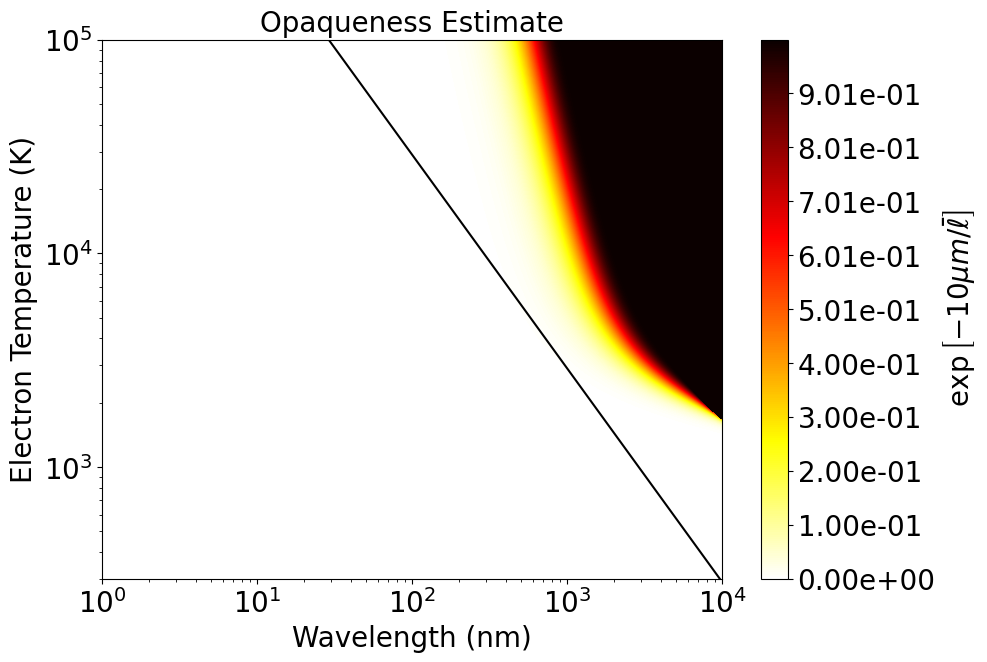

In [6]:
plt.figure(figsize=(10, 7))

orig_map=plt.cm.get_cmap('hot')
reversed_hot = orig_map.reversed()

contour = plt.contourf(λ_values*1e9, Te_values, 1-np.exp(-50/lγ_grid), levels=np.linspace(0,1,num=1000), cmap=reversed_hot)#, norm=norm)

# Create colorbar, add label, and set label size
cbar = plt.colorbar(contour, format=FuncFormatter(lambda x, pos: "{:.2e}".format(x)))
cbar.set_label(r" $\exp\left[-10 \mu m/\bar{\ell} \right]$ ", size=20)
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_ylim(0,1)

plt.plot(λ_values*1e9, 2.897e-3/λ_values ,'k', label=r"$\lambda_{peak}$")

# Axes
plt.xscale('log')
plt.yscale('log')
plt.ylim(np.min(Te_values), np.max(Te_values))

# Set label sizes
plt.xlabel('Wavelength (nm)', fontsize=20)
plt.ylabel('Electron Temperature (K)', fontsize=20)
plt.title('Opaqueness Estimate', fontsize=20)

# Set tick label sizes
plt.tick_params(labelsize=20, which='both')

plt.show()

/tmp/ipykernel_4992/927408007.py:9: RuntimeWarning: invalid value encountered in sqrt
  contour = plt.contourf(λ_values*1e9, Te_values, crit_ratio_grid/np.sqrt(1-crit_ratio_grid), levels=levels, cmap='jet', norm=norm)


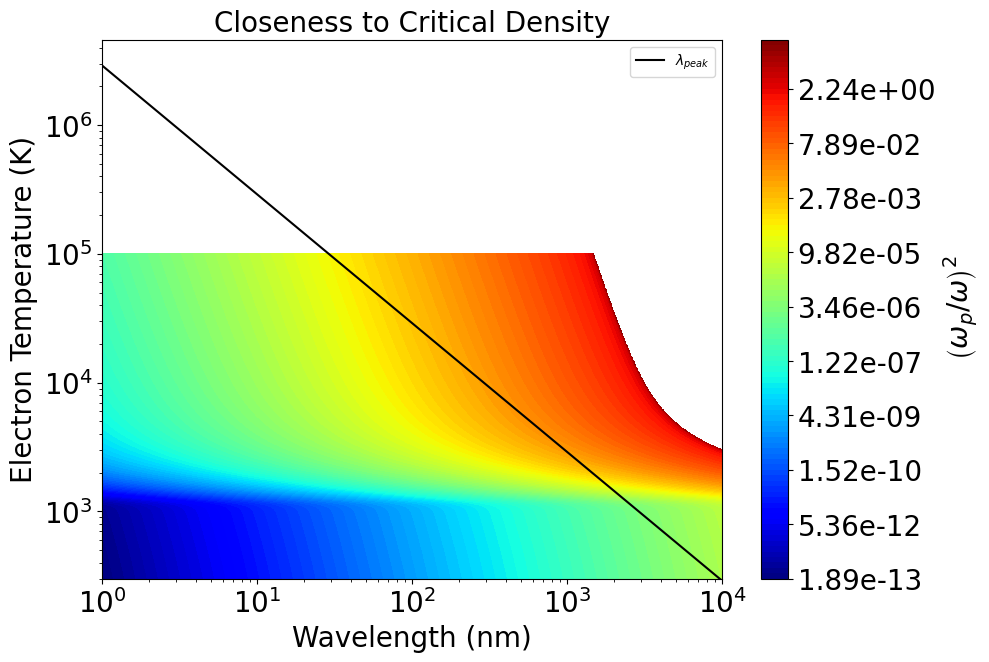

In [7]:
plt.figure(figsize=(10, 7))

n_e_grid = n0*ttm.experiment.get_ionization(Z, n0, Te_grid)
ωp_grid = JT_GMS.electron_plasma_frequency(n_e_grid)
crit_ratio_grid = (ωp_grid/ω_grid)**2

norm = LogNorm(vmin=crit_ratio_grid.min(), vmax=crit_ratio_grid.max())
levels = np.logspace(np.log10(crit_ratio_grid.min()), np.log10(crit_ratio_grid.max()), num=100)
contour = plt.contourf(λ_values*1e9, Te_values, crit_ratio_grid/np.sqrt(1-crit_ratio_grid), levels=levels, cmap='jet', norm=norm)

# Create colorbar, add label, and set label size
cbar = plt.colorbar(contour, format=FuncFormatter(lambda x, pos: "{:.2e}".format(x)))
cbar.set_label(r" $\left( \omega_p/\omega \right)^2$ ", size=20)
cbar.ax.tick_params(labelsize=20)

plt.plot(λ_values*1e9, 2.897e-3/λ_values ,'k', label=r"$\lambda_{peak}$")

plt.xscale('log')
plt.yscale('log')

# Set label sizes
plt.xlabel('Wavelength (nm)', fontsize=20)
plt.ylabel('Electron Temperature (K)', fontsize=20)
plt.title('Closeness to Critical Density', fontsize=20)

# Set tick label sizes
plt.tick_params(labelsize=20, which='both')

plt.legend()
plt.show()

## Ionization Correction

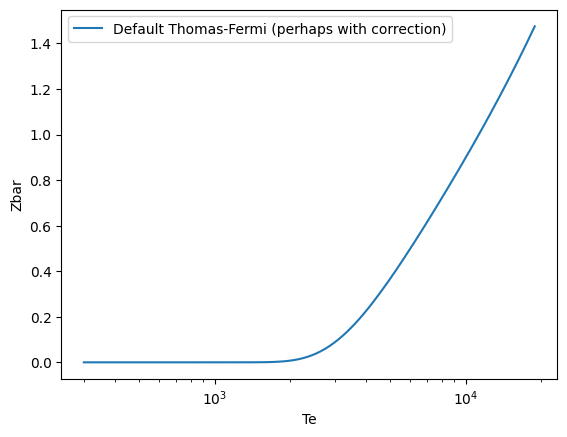

In [8]:
fig, ax = plt.subplots()

ax.plot(ttm.Te, ttm.Zbar, label='Default Thomas-Fermi (perhaps with correction)')
# ax.plot(ttm.Te, ttm.Zbar, '--', label="'Corrected' Thomas-Fermi")

ax.set_xscale('log')
ax.set_xlabel('Te')
ax.set_ylabel('Zbar')
ax.legend()


# Get Intensity From Absorption Integral over Line of Sight

In [ ]:
class Measurements():
    
    def __init__(self, Z, A, r_array, n_e_array, n_i_array, Te_array, Ti_array, R_max = 100e-6, Nx = 100, Nz=500):
        self.Z, self.A = Z, A
        self.r_array  = r_array
        self.n_e_array = n_e_array
        self.n_i_array = n_i_array
        self.Te_array  = Te_array
        self.Ti_array  = Ti_array
        self.Zbar_array= self.n_e_array/self.n_i_array
        
        self.m_i = A*m_p
        
        self.x, self.z = np.linspace(-R_max,R_max, num=Nx), np.linspace(-R_max,R_max, num=Nz)
        self.dx, self.dz = self.x[1]-self.x[0], self.z[1]-self.z[0]
        self.X, self.Z = np.meshgrid(self.x,self.z, indexing='ij')
        self.ρ_grid = np.sqrt(self.X**2 + self.Z**2)
        
        self.make_parameter_grids()
        self.make_eff_parameters()
        self.make_spectral_parameters()
        self.fit_Te_with_spectral_Intensity()

    def convert_r_array_to_grid(self, array, fill_value='extrapolate'):
        array_func = interp1d(self.r_array, array, bounds_error=False, fill_value=fill_value)
        grid = array_func(self.ρ_grid)
        return grid

    def make_parameter_grids(self):
        self.n_e_grid = self.convert_r_array_to_grid(self.n_e_array)
        self.n_i_grid = self.convert_r_array_to_grid(self.n_i_array)
        self.Te_grid  = self.convert_r_array_to_grid(self.Te_array)
        self.Ti_grid  = self.convert_r_array_to_grid(self.Ti_array)
        self.Zbar_grid= self.convert_r_array_to_grid(self.Zbar_array)
        
    def make_εeff_grid(self):
        self.ε_grid = np.zeros_like(self.κeff_grid)
        for x_i in range(self.κeff_grid.shape[0]):
            for z_i in range(self.κeff_grid.shape[1]):
                self.ε_grid[x_i, z_i] = np.exp(-np.sum(self.dz*self.κeff_grid[x_i,:z_i]))
        return self.ε_grid

    def make_ε_grid(self):
        self.ε_grid = np.zeros((len(self.x), len(self.z), len(self.ωs)))
        for x_i in range(len(self.x)):
            for z_i in range(len(self.z)):
                self.ε_grid[x_i, z_i, :] = np.exp(-np.sum(self.κ_grid[x_i,:z_i,:]*self.dz,axis=0))
        return self.ε_grid

    def make_eff_parameters(self):
        self.κeff_grid = np.nan_to_num(JT_GMS.effective_photon_absorption_coefficient(self.m_i, self.n_i_grid, 
                                                                                       self.n_e_grid, self.Ti_grid, 
                                                                                       self.Te_grid, self.Zbar_grid), nan=1e8)
        self.εeff_grid = self.make_εeff_grid() 
        self.Ieff_grid = self.Te_grid**4*self.εeff_grid
        self.Ieff_unnormalized = np.array([np.sum(self.dz*self.Te_grid[x_i]**4*self.εeff_grid[x_i])/1e16 for x_i in range(len(self.x))])

    def make_spectral_parameters(self):
        self.ωs = k_B/hbar*np.geomspace(np.min(self.Te_grid*10), np.max(self.Te_grid*100),num=200 )
        self.dω = self.ωs[1:]-self.ωs[:-1]
        self.λs = 2*π*c/self.ωs[::-1]
        self.dλ = self.λs[1:]-self.λs[:-1]

        self.κ_grid = JT_GMS.photon_absorption_coefficient(self.ωs[np.newaxis,np.newaxis,:], self.m_i,
                                                            self.n_i_grid[:,:,np.newaxis], 
                                                            self.n_e_grid[:,:,np.newaxis], 
                                                            self.Ti_grid[:,:,np.newaxis], 
                                                            self.Te_grid[:,:,np.newaxis], 
                                                            self.Zbar_grid[:,:,np.newaxis])
        self.κ_grid = np.nan_to_num(self.κ_grid, nan=1e10)

        self.Bω_grid = JT_GMS.photon_angular_frequency_density(self.ωs[np.newaxis,np.newaxis,:],self.Te_grid[:,:,np.newaxis])
        self.Bλ_grid = JT_GMS.photon_wavelength_density(self.λs[np.newaxis,np.newaxis,:],self.Te_grid[:,:,np.newaxis])

        self.ε_grid = self.make_ε_grid() 
        self.Iω_grid = self.Bω_grid * self.ε_grid
        self.Iλ_grid = self.Bλ_grid * self.ε_grid
        # ω
        self.Iω_unnormalized_of_r = np.array([np.sum(self.Iω_grid[x_i], axis=0) for x_i in range(len(self.x))])
        self.Iω_unnormalized = np.sum(self.Iω_unnormalized_of_r*self.dx, axis=0)
        self.I_unnormalized_of_r = np.sum(self.Iω_unnormalized_of_r[:,1:]*self.dω[np.newaxis,:], axis=1)
        # λ
        self.Iλ_unnormalized_of_r = np.array([np.sum(self.Iλ_grid[x_i], axis=0) for x_i in range(len(self.x))])
        self.Iλ_unnormalized = np.sum(self.Iλ_unnormalized_of_r*self.dx, axis=0)
        
        FWHM_index = np.argmin(np.abs(self.I_unnormalized_of_r-np.max(self.I_unnormalized_of_r)/2 )) 
        self.FWHM = np.abs(2*self.x[FWHM_index])

    def plot_parameter(self, parameter_grid, label=''):
        plt.figure(figsize=(10, 7))
        contour = plt.contourf(self.X*1e6, self.Z*1e6, parameter_grid, levels=100, cmap='viridis')

        cbar = plt.colorbar(contour)
        cbar.set_label(label, size=20)
        cbar.ax.tick_params(labelsize=20)

        plt.xlabel('x [μm]', fontsize=20)
        plt.ylabel('z [μm]', fontsize=20)

        plt.tick_params(labelsize=20)

        plt.show()
        
    def plot_emissivity_and_intensity(self,Intensity_grid):
        # Gridspec is now 2x2 with sharp width ratios
        gs = gridspec.GridSpec(2,2,height_ratios=[4,1],width_ratios=[20,1])
        fig = plt.figure(figsize=(8,6))

        # Contour plot axis
        cax = fig.add_subplot(gs[0])

        # Create the contour plot
        contour = cax.contourf(self.X*1e6, self.Z*1e6, self.εeff_grid, levels=100, cmap='viridis')
        cax.set_ylabel('z (μm)', fontsize=20)
        cax.tick_params(labelsize=20)

        # Intensity plot axis
        lax = fig.add_subplot(gs[2], sharex=cax)

        # Create the Intensity plot
        lax.plot(self.X[:,0]*1e6, Intensity_grid/np.max(Intensity_grid), color='b')
        lax.set_xlabel('x (μm)', fontsize=20)
        lax.set_ylabel('Intensity', fontsize=20)
        lax.tick_params(labelsize=20)
        lax.set_ylim(0,1)

        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        
        textstr = "FWHM = {0:.1f} μm".format(self.FWHM*1e6)
        lax.text(0.03, 0.93, textstr, transform=lax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

        # Make a subplot for the colour bar
        bax = fig.add_subplot(gs[1])

        # Use general colour bar with specific axis given.
        cbar = plt.colorbar(contour, cax=bax)
        cbar.set_label('Emissivity', size=20)
        cbar.ax.tick_params(labelsize=20)

        plt.tight_layout()
        plt.show()
        
    def fit_Te_with_spectral_Intensity(self):
        test_Boltzmann = lambda Te: JT_GMS.photon_wavelength_density(self.λs, Te)
        f_to_min = lambda Te: np.linalg.norm( self.Iλ_unnormalized/np.max(self.Iλ_unnormalized) - test_Boltzmann(Te)/np.max(test_Boltzmann(Te)) )
        sol = root(f_to_min, 1e4)
        self.Te_fit = sol.x
        self.spectral_intensity_fit = test_Boltzmann(self.Te_fit)

    def plot_spectral_Intensity(self):
        self.fit_Te_with_spectral_Intensity()

        plt.figure(figsize=(10, 7))
        plt.plot(self.λs*1e9, self.Iλ_unnormalized/np.max(self.Iλ_unnormalized), label="Integrated over profile")
        plt.plot(self.λs*1e9, self.spectral_intensity_fit/np.max(self.spectral_intensity_fit), label="Te={0:.1f} kK".format(self.Te_fit[0]*1e-3))

        plt.xlabel('λ [nm]', fontsize=20)
        plt.ylabel('Normalized Intensity', fontsize=20)

        plt.legend(fontsize=20)
        plt.tick_params(labelsize=20)

        plt.show()

In [ ]:
exp_measurement = Measurements(Z, A, ttm.grid.r, ttm.n_e, ttm.n_i, ttm.Te, ttm.Ti, R_max = 100e-6, Nx = 100, Nz=500)

In [ ]:
exp_measurement.plot_emissivity_and_intensity(exp_measurement.I_unnormalized_of_r)#fit_Te_with_spectral_Intensity()

In [ ]:
exp_measurement.fit_Te_with_spectral_Intensity()

In [ ]:
1300*1.19/60

In [ ]:
%%time
i=0
exp_i = Measurements(Z, A, ttm.grid.r, ttm.n_e_list[i], ttm.n_i_list[i], ttm.Te_list[i], ttm.Ti_list[i], R_max = 100e-6, Nx = 1000, Nz=500)
exp_i.FWHM

In [ ]:
%%time
i=1
exp_i = Measurements(Z, A, ttm.grid.r, ttm.n_e_list[i], ttm.n_i_list[i], ttm.Te_list[i], ttm.Ti_list[i], R_max = 100e-6, Nx = 1000, Nz=500)
exp_i.FWHM

In [ ]:
FWHM_list = []
FWHM_t_list = ttm.t_saved_list[:1400][::100]
# Te_fit_list = []

for i, ti in enumerate(ttm.t_saved_list[:1400][::100]):
    exp_i = Measurements(Z, A, ttm.grid.r, ttm.n_e_list[i], ttm.n_i_list[i], ttm.Te_list[i], ttm.Ti_list[i], R_max = 100e-6, Nx = 1000, Nz=500)
    FWHM_list.append(exp_i.FWHM)
#     Te_fit_list.append(exp_i.Te_fit)

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle("Full Experimental Fit and Simulation in Xe at 5 bar", fontsize=20)

ax.plot(np.array(ttm.t_saved_list[:1400])*1e9, np.array(Te_fit_list[:1400])/1e3,'--.', color='r')
ax.set_ylabel(r'$T_e$ [kK]', fontsize=20, color='r')
ax.set_xlabel('t [ns]', fontsize=20)
# ax.set_xlim(0,12)

# ax.set_ylim(40,60)
ax.tick_params(labelsize=20)

ax2 = ax.twinx()
ax2.plot(np.array(FWHM_t_list)*1e9, np.array(FWHM_list)*1e6,'--.k')
ax2.set_ylabel('FWHM [$\mu$m]', fontsize=20)
ax2.tick_params(labelsize=20)

# Comparison to Experiment

In [ ]:
Xe_data = read_csv("./data/experimental_data/Xe_5bar_Te.txt", delim_whitespace=True, header=1)

In [ ]:
from scipy.optimize import curve_fit

def T_fit_form(t, Te_0, Ti_0, d, τei):
    ΔT0 = (Te_0-Ti_0)
    ΣT0 = (Te_0+Ti_0)
    return ΣT0/2 - d*t + ΔT0/2*np.exp(-2*t/τei)

def T_DIHfit_form(t, Te_0, d, τei):
    Ti_0 = Ti_initial
    ΔT0 = (Te_0-Ti_0)
    ΣT0 = (Te_0+Ti_0)
    return ΣT0/2 - d*t + ΔT0/2*np.exp(-2*t/τei)

Te0_fit, Ti0_fit, d_fit, τei_fit = curve_fit(T_fit_form, Xe_data['t[ns]'], Xe_data['T[kK]'] )[0]
Te0_DIHfit, d_DIHfit, τei_DIHfit = curve_fit(T_DIHfit_form, Xe_data['t[ns]'], Xe_data['T[kK]'] )[0]
Te0_DIHfit, d_DIHfit, τei_DIHfit

In [ ]:
def plot_bulk_temperature(ttm, exp, plot_times = None, ax = None, title=''):
    bulk_Tes = np.array(Te_fit_list)

    ti_1, ti_2 = -100, -1

    dT_dt  = (T_av_2 - T_av_1)/(ttm.t_list[ti_2] - ttm.t_list[ti_1])

    T_eq_line  = np.array(T_av_1 + dT_dt*(ttm.t_list-ttm.t_list[ti_1]))


    ax.plot(np.array(ttm.t_saved_list)*1e9, bulk_Tes*1e-3,label=r"$T_e$ (bulk)")
#     ax.plot(np.array(ttm.t_list)*1e9, bulk_Tis*1e-3,label=r"$T_i$ (bulk)")
#     ax.plot(np.array(ttm.t_list)*1e9, T_eq_line*1e-3,'--k',label='Linear Diffusion line')
#     ax.plot(np.array(ttm.t_list)*1e9, T_av*1e-3,'-k',label='Average (initial: T={0:.2f} [kK])'.format(T_av[0]*1e-3))
    
#     bulk_T_exp_fit = (Te_initial + Ti_initial)/2 - 0.5*120*1e9*ttm.t_list + (Te_initial - Ti_initial)/2 * np.exp(-ttm.t_list/(1470e-12))
#     print(bulk_T_exp_fit)
    ax.plot(ttm.t_saved_list*1e9, T_fit_form(ttm.t_saved_list*1e9, Te0_fit, Ti0_fit, d_fit, τei_fit),'r--' ,label="Experiment Fit")
    ax.plot(ttm.t_saved_list*1e9, T_DIHfit_form(ttm.t_saved_list*1e9, Te0_fit, d_fit, τei_fit),'r-.' ,label="Experiment DIH fixed Fit")
    ax.plot(Xe_data['t[ns]'], Xe_data['T[kK]'], 'r-', label='Experiment Data')
    # Thermalization Text
    thermalization_text = r'$\tau_{th}$' + ' = {0:.1f} [ps] (exp 1470 ps)'.format(ttm.experiment.τei_Equilibration*1e12)
    thermalization_head_x_pos = 0.5* ttm.experiment.τei_Equilibration*1e9
    thermalization_head_y_pos = bulk_Tes[np.argmin(np.abs(ttm.t_list-thermalization_head_x_pos*1e-9))]*1e-3
    
    thermalization_arrow_head_coords = (thermalization_head_x_pos, thermalization_head_y_pos )
    ax.annotate(thermalization_text, xy=thermalization_arrow_head_coords, xycoords='data',
                xytext=(150, 60), textcoords='offset points',
                va='top', ha='left',fontsize=15,
                arrowprops=dict(facecolor='black', shrink=0.02))

    # Diffusion Text
    diffusion_text = 'Diffusion Estimate:\n dT/dt={0:.2f} [K/ns] (exp -120 K/ns)'.format(dT_dt*1e-9)
    diffusion_head_x_pos = 0.5*ttm.tmax*1e9
    diffusion_head_y_pos = 0.1 + bulk_Tes[np.argmin(np.abs(ttm.t_list-diffusion_head_x_pos*1e-9))]*1e-3
    
    diffusion_arrow_head_coords = (diffusion_head_x_pos, diffusion_head_y_pos )
    ax.annotate(diffusion_text, xy=diffusion_arrow_head_coords, xycoords='data',
                xytext=(60, 30), textcoords='offset points',
                va='top', ha='left',fontsize=15,
                arrowprops=dict(facecolor='black', shrink=0.02))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)

    # place a text box in upper left in axes coords
    fit_string =  (r"My fit: $τ_{{ei}}$ = {0:.1f} [ps]".format(τei_fit*1e3) + '\n'+
                   r" $dT_e/dt$ = -{0:.1f} K/ns".format(d_fit*1e3) + '\n' +
                   r" $T^{{\rm init}}_e$ = {0:.2f} [kK]".format(Te0_fit) + '\n' +
                   r" $T^{{\rm init}}_i$ = {0:.2f} [kK]".format(Ti0_fit)

                  )
    ax.text(0.5, 0.95, fit_string, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)



    # Plot settings
    ax.set_xlabel(r"Time [ns]", fontsize=20)
    ax.set_ylabel("Temperature [kK]",fontsize=20)
    ax.tick_params(labelsize=20)
    ax.set_xlim(-0.1,ttm.tmax*1e9)
    ax.set_ylim(10,17)

    ax.set_title(title,fontsize=20)
    ax.legend(fontsize=14)
    ax.grid(alpha=0.3)
